# Job state prediction
## AI in Industry - Exam + Project work
### Davide Buldrini (davide.buldrini@studio.unibo.it), Nicolò Donati (nicolo.donati4@studio.unibo.it), Guido Laudenzi (guido.laudenzi@studio.unibo.it)

The purpose of this notebook is about predicting the output state of the job
using only the information available prior to its execution.
Potentially, it can be used to reduce the ques in HPC
environments, skipping or giving low priority to jobs that are
likely to not complete the execution.

Plenty appreaches were implemented:

* Time Series,
* Random Forest classifier,
* XGBoost classifier,
* Sentence Bert using diffent classification heads,
* TabTransformer,
* GATE.

## Configs

In [ ]:
!git clone https://github.com/yg211/explainable-metrics
!mv /content/explainable-metrics/* /content/
!rm -r /content/explainable-metrics

In [ ]:
!pip install lime
!pip install shap
!pip install datasets
!pip install tensorflow-addons
!pip install sentence_transformers

import gc
import lime
import nltk
import shap
import torch
import os, random
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
import tensorflow as tf
import lime.lime_tabular
import multiprocessing as mp
import matplotlib.pyplot as plt
import tensorflow_addons as tfa

from torch import nn
from typing import Iterable
from tensorflow import keras
from datasets import Dataset
from google.colab import drive
from tensorflow.keras import layers
from sklearn.utils import shuffle
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC, SVC
from sts_pair_explainer import ExplainableSTS
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import StackingClassifier, VotingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.naive_bayes import (GaussianNB, MultinomialNB, ComplementNB,
                                BernoulliNB, CategoricalNB)
from sentence_transformers import SentenceTransformer, losses, models
from transformers import (DefaultDataCollator, TrainingArguments, Trainer,
                         BertForSequenceClassification, BertTokenizer, set_seed)

Gate packages

In [ ]:
!pip install pytorch_tabular
!pip install --upgrade torch

from pytorch_tabular import TabularModel
from pytorch_tabular.models import (
    CategoryEmbeddingModelConfig,
    FTTransformerConfig,
    TabNetModelConfig,
    GatedAdditiveTreeEnsembleConfig,
    TabTransformerConfig,
    AutoIntConfig
)
from pytorch_tabular.config import DataConfig, OptimizerConfig, TrainerConfig, ExperimentConfig
from pytorch_tabular.models.common.heads import LinearHeadConfig
nltk.download('punkt')

In [ ]:
drive.mount('/content/gdrive')

## Utils

In [ ]:
# Mapping for report; depends on chosen labels
d = {0: 'completed', 1: 'failed', 2: 'oom', 3:'time-out'}

In [ ]:
# Reproducibility setting seed 42

def seed_everything(seed: int):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    set_seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

s = 42
seed_everything(s)

In [ ]:
class MultiColumnLabelEncoder:
    def __init__(self, columns = None):
        self.columns = columns # array of column names to encode

    def fit(self,X,y=None):
        return self # not relevant here

    def transform(self,X):
        '''
        Transforms columns of X specified in self.columns using
        LabelEncoder(). If no columns specified, transforms all
        columns in X.
        '''
        output = X.copy()
        if self.columns is not None:
            for col in self.columns:
                output[col] = LabelEncoder().fit_transform(output[col])
        else:
            for colname,col in output.iteritems():
                output[colname] = LabelEncoder().fit_transform(col)
        return output

    def fit_transform(self,X,y=None):
        return self.fit(X,y).transform(X)

In [ ]:
def date_dataset():
  #load
  dataset = pd.read_parquet('/content/gdrive/MyDrive/job_state/job_tres_state_parsed_date.parquet')

  #standard preprocess
  dataset['req_nodes'].replace('', '['']', inplace=True)
  dataset['time_limit'].replace('', 0, inplace=True)
  dataset['cpus_per_task'].replace('', 0, inplace=True)
  dataset = dataset.drop(['start_time','end_time'], axis=1)
  dataset = dataset.drop(dataset[dataset['job_state']=='CANCELLED'].index)
  dataset = dataset.drop(dataset[dataset['job_state']=='NODE_FAIL'].index)
  dataset = dataset.drop(dataset[dataset['job_state']=='PREEMPTED'].index)
  dataset = dataset.drop(['exclusive','ntasks_per_node'], axis=1)
  dataset['time_limit'] = dataset['time_limit'].astype(int)
  dataset.insert(len(dataset.columns)-1, 'job_state', dataset.pop('job_state'))

  return dataset

In [ ]:
def plot_dataframe(data, vrows, labels=None, vmin=-1.96, vmax=1.96,
        figsize=(9, 3), s=4):
    plt.figure(figsize=figsize)
    plt.imshow(data.T.iloc[:, :], aspect='auto',
            cmap='RdBu', vmin=vmin, vmax=vmax)
    if labels is not None:
        # nonzero = data.index[labels != 0]
        ncol = len(data.columns)
        lvl = - 0.05 * ncol
        # plt.scatter(nonzero, lvl*np.ones(len(nonzero)),
        #         s=s, color='tab:orange')
        plt.scatter(labels.index, np.ones(len(labels)) * lvl,
                s=s,
                color=plt.get_cmap('tab10')(labels))

    for i in vrows:
      plt.axvline(x = i, color = 'g')
    plt.tight_layout()

In [ ]:
def load_dataset(train = True, undersample = False):
  #load
  if train:
    dataset = pd.read_parquet('/content/gdrive/MyDrive/job_state/jobs_table_state_parsed.parquet')
  else:
    dataset = pd.read_parquet('/content/gdrive/MyDrive/job_state/job_tres_state_parsed.parquet')

  #standard preprocess
  dataset['req_nodes'].replace('', '['']', inplace=True)
  dataset['time_limit'].replace('', 0, inplace=True)
  dataset['cpus_per_task'].replace('', 0, inplace=True)
  dataset = dataset.drop(['start_time','end_time'], axis=1)
  dataset = dataset.drop(dataset[dataset['job_state']=='CANCELLED'].index)
  dataset = dataset.drop(dataset[dataset['job_state']=='NODE_FAIL'].index)
  dataset = dataset.drop(dataset[dataset['job_state']=='PREEMPTED'].index)
  if train:
    dataset = dataset.drop(['shared','nodes_allocated'], axis=1)
    dataset.rename(columns = {'num_cpus':'cpu', 'num_nodes':'node', 'num_gpus': 'gres/gpu', 'memory': 'mem'}, inplace = True)
    dataset['time_limit'] = dataset['time_limit'].astype(int)*60
    dataset['cpus_per_task'] = dataset['cpus_per_task'].astype(int)
    dataset['cpu'] = dataset['cpu'].astype(int)
    dataset['node'] = dataset['node'].astype(int)
    dataset['mem'] = dataset['mem'].astype(int)
  else:
    dataset = dataset.drop(['exclusive','ntasks_per_node'], axis=1)
    dataset['time_limit'] = dataset['time_limit'].astype(int)

  #drop duplicates
  dataset = dataset.drop_duplicates(subset=[i for i in list(dataset) if i!="job_id" or "job_state"])

  #optional undersampling
  if undersample:
    completed = dataset[dataset['job_state']=='COMPLETED']
    uncompleted = dataset[dataset['job_state']!='COMPLETED']
    completed = completed.sample(n=len(uncompleted), random_state=s)
    dataset = pd.concat([completed,uncompleted],axis=0)

  dataset.insert(len(dataset.columns)-1, 'job_state', dataset.pop('job_state'))
  return shuffle(dataset, random_state=s)

In [ ]:
def manage_dataset(setup=0, real = 0):
    types = {"job_id": object, "user_id": object, "group_id": object,
          "cpus_per_task": "int64", "command": object, "name": object,
          "account": object, "partition": object, "qos": object,
          "time_limit": "int64", "req_nodes": object, "cpu": "int64",
          "mem": "float64", "node": "int64", "gres/gpu": "int64",
    }
    if real == 0:
        if setup == 0:
              # Train e test D1
              df = load_dataset(train = False, undersample = True)
              df_train, df_val = train_test_split(df, test_size = 0.2, random_state = s)
        elif setup == 1:
              df = load_dataset(train = True, undersample = True)
              for k, v in types.items():
                  df[k] = df[k].astype(v)
              df_train, df_val = train_test_split(df, test_size = 0.2, random_state = s)
        elif setup == 2:
              df_train = load_dataset(train = False, undersample = True)
              df_val = load_dataset(train = True, undersample = True)
              df_val = df_val[~df_val.job_id.isin(df_train.job_id.values.tolist())]
              for k, v in types.items():
                  df_val[k] = df_val[k].astype(v)
        elif setup == 3:
              df_train = load_dataset(train = True, undersample = True)
              df_val = load_dataset(train = False, undersample = True)
              df_train = df_train[~df_train.job_id.isin(df_val.job_id.values.tolist())]
              for k, v in types.items():
                  df_train[k] = df_train[k].astype(v)
              df_train, _ = train_test_split(df_train, test_size = 0.2, random_state = 42)
        else:
              return "Something's wrong with the input"
    elif real == 1:
        if setup == 0:
              # Train e test D1
              df = load_dataset(train = False, undersample = False)
              df_train, df_val = train_test_split(df, test_size = 0.2, random_state = s)
              completed = df_train[df_train['job_state']=='COMPLETED']
              uncompleted = df_train[df_train['job_state']!='COMPLETED']
              completed = completed.sample(n=len(uncompleted), random_state=s)
              df_train = pd.concat([completed,uncompleted],axis=0)
              df_val, _ = train_test_split(df_val, test_size = 0.3, random_state = s)
        elif setup == 1:
              df = load_dataset(train = True, undersample = False)
              for k, v in types.items():
                  df[k] = df[k].astype(v)
              df_train, df_val = train_test_split(df, test_size = 0.2, random_state = s)
              completed = df_train[df_train['job_state']=='COMPLETED']
              uncompleted = df_train[df_train['job_state']!='COMPLETED']
              completed = completed.sample(n=len(uncompleted), random_state=s)
              df_train = pd.concat([completed,uncompleted],axis=0)
              df_val, _ = train_test_split(df_val, test_size = 0.3, random_state = s)
        elif setup == 2:
              df_train = load_dataset(train = False, undersample = True)
              df_val = load_dataset(train = True, undersample = False)
              df_val = df_val[~df_val.job_id.isin(df_train.job_id.values.tolist())]
              for k, v in types.items():
                  df_val[k] = df_val[k].astype(v)
              df_val, _ = train_test_split(df_val, test_size = 0.5, random_state = s)
        elif setup == 3:
              df_train = load_dataset(train = True, undersample = True)
              df_val = load_dataset(train = False, undersample = False)
              df_train = df_train[~df_train.job_id.isin(df_val.job_id.values.tolist())]
              for k, v in types.items():
                  df_train[k] = df_train[k].astype(v)
              df_train, _ = train_test_split(df_train, test_size = 0.2, random_state = s)
              df_val, _ = train_test_split(df_val, test_size = 0.3, random_state = s)
        else:
              return "Something's wrong with the input"
    else:
        return "Something's wrong with the input"

    print('Data shape:', df_train.shape, df_val.shape)

    le = LabelEncoder()
    le.fit(df_train['job_state'])
    df_train['job_state'] = le.transform(df_train['job_state'])
    df_val['job_state'] = le.transform(df_val['job_state'])

    print('### Train stats ###')
    print('Completed jobs:', len(df_train[df_train['job_state']==0]))
    print('Failed jobs:', len(df_train[df_train['job_state']==1]))
    print('OOM jobs:', len(df_train[df_train['job_state']==2]))
    print('Time-out jobs:', len(df_train[df_train['job_state']==3]))
    print('### Val stats ###')
    print('Completed jobs:', len(df_val[df_val['job_state']==0]))
    print('Failed jobs:', len(df_val[df_val['job_state']==1]))
    print('OOM jobs:', len(df_val[df_val['job_state']==2]))
    print('Time-out jobs:', len(df_val[df_val['job_state']==3]))

    return df_train, df_val

In [ ]:
class SBertBaseline:
    def __init__(self):
        self.classifier = RandomForestClassifier(max_depth=20,
                                                 verbose=True,
                                                 random_state=42)
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2') #all-mpnet-base-v2

        # word_embedding_model = models.Transformer('allenai/scibert_scivocab_uncased')
        # pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        # self.encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])

    def prepare_data(self, data:Iterable, parallel:bool = False) -> Iterable:
        """_summary_

        Args:
            data (Iterable): Data to be parsed
            parallel (bool, optional): If true uses multiprocessing, make sure to keep the same order of the original data, not granted with async. Defaults to False.

        Returns:
            Iterable: The parsed data
        """
        if type(data[0]) != str:
            data = list(map(self._embed_entry, data))
        if parallel:
            with mp.Pool(os.cpu_count()) as p:
                res = p.map_async(self.encoder.encode, data).get()
            return res
        return self.encoder.encode(data)

    def fit(self, x_train:Iterable, y_train:Iterable) -> None:
        """_summary_

        Args:
            x_train (Iterable): training features
            y_train (Iterable): training labels
        """
        self.classifier = self.classifier.fit(self.prepare_data(x_train), y_train)

    def predict(self, x) -> Iterable:
        """_summary_

        Args:
            x (_type_): Data to be analyzed

        Returns:
            Iterable: The labels predicted for the input data
        """
        return self.classifier.predict(self.prepare_data(x))

    def predict_proba(self, x) -> Iterable:
        """_summary_

        Args:
            x (_type_): Data to be analyzed

        Returns:
            Iterable: The labels predicted probabilities for the input data
        """
        return self.classifier.predict_proba(x) #self.prepare_data(x)

    @staticmethod
    def _embed_entry(entry:dict, use_keys = True):
        return ",".join([f"{str(k)}={str(entry[k])}" for k in entry])

In [ ]:
class SBertXGBoost:
    def __init__(self):
        self.classifier = xgb.XGBClassifier(objective='multi:softmax',
                                            num_class=4,
                                            tree_method = "gpu_hist",
                                            learning_rate=0.1,
                                            max_depth=20,
                                            seed=42)
        self.encoder = SentenceTransformer('all-MiniLM-L6-v2') #all-mpnet-base-v2

        # word_embedding_model = models.Transformer('allenai/scibert_scivocab_uncased')
        # pooling_model = models.Pooling(word_embedding_model.get_word_embedding_dimension())
        # self.encoder = SentenceTransformer(modules=[word_embedding_model, pooling_model])


    def prepare_data(self, data:Iterable, parallel:bool = False) -> Iterable:
        """_summary_

        Args:
            data (Iterable): Data to be parsed
            parallel (bool, optional): If true uses multiprocessing, make sure to keep the same order of the original data, not granted with async. Defaults to False.

        Returns:
            Iterable: The parsed data
        """
        if type(data[0]) != str:
            data = list(map(self._embed_entry, data))
        if parallel:
            with mp.Pool(os.cpu_count()) as p:
                res = p.map_async(self.encoder.encode, data).get()
            return res
        return self.encoder.encode(data)

    def fit(self, x_train:Iterable, y_train:Iterable) -> None:
        """_summary_

        Args:
            x_train (Iterable): training features
            y_train (Iterable): training labels
        """
        self.classifier = self.classifier.fit(self.prepare_data(x_train), y_train)

    def predict(self, x) -> Iterable:
        """_summary_

        Args:
            x (_type_): Data to be analyzed

        Returns:
            Iterable: The labels predicted for the input data
        """
        return self.classifier.predict(self.prepare_data(x))

    @staticmethod
    def _embed_entry(entry:dict, use_keys = True):
        return ",".join([f"{str(k)}={str(entry[k])}" for k in entry])

## Anomaly detection

In [ ]:
df_anomaly = date_dataset()

In [ ]:
enc_anomaly = MultiColumnLabelEncoder(columns = ['command','name','account','partition','qos',
                                         'job_state','req_nodes', 'year_month'])
df_anomaly = enc_anomaly.fit_transform(df_anomaly)
df_anomaly = df_anomaly.astype('int64')

In [ ]:
df_anomaly.sort_values(['year_month','job_id'], inplace = True, ignore_index=True)

In [ ]:
df_anomaly

In [ ]:
v = []
s = df_anomaly['year_month'][0]
for i in range(df_anomaly.shape[0]):
  if df_anomaly['year_month'].iloc[i] != s:
    v.append(i)
    s = df_anomaly['year_month'].iloc[i]

In [ ]:
labels = ["cpus_per_task", "command", "name", "partition", "qos", "time_limit", "req_nodes", "cpu", "mem", "node", "gres/gpu"]

In [ ]:
an = df_anomaly[labels]

In [ ]:
an = (an - an.mean()) / an.std()

In [ ]:
plot_dataframe(an,v)

In [ ]:
labels = LabelEncoder()
labels.fit(df_anomaly['job_state'])
df_anomaly['job_state'] = labels.transform(df_anomaly['job_state'])

labels = pd.Series(index=an.index, data=df_anomaly['job_state'], dtype=int)

In [ ]:
plot_dataframe(an,v,labels)

### PCA

In [ ]:
X_std = StandardScaler().fit_transform(df_anomaly.iloc[:,:15])
X_pca = PCA(n_components=2).fit_transform(X_std)
X_pca = np.vstack((X_pca.T, df_anomaly.iloc[:,16])).T
df_pca = pd.DataFrame(X_pca, columns=['1st_Component','2nd_Component','class'])
df_pca.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_pca, hue='class', x='1st_Component', y='2nd_Component')
plt.show()

### t-SNE

In [ ]:
sample_sne = df_anomaly.sample(10000)
X_std_sne = StandardScaler().fit_transform(sample_sne.iloc[:,:15])
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X_std_sne)
X_tsne_data = np.vstack((X_tsne.T, sample_sne.iloc[:,16])).T
df_tsne = pd.DataFrame(X_tsne_data, columns=['Dim1', 'Dim2', 'class'])
df_tsne.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_tsne, hue='class', x='Dim1', y='Dim2')
plt.show()

### LDA

In [ ]:
lda = LinearDiscriminantAnalysis(n_components=2)
X_lda = lda.fit_transform(X_std, df_anomaly.iloc[:,16])
X_lda_data = np.vstack((X_lda.T, df_anomaly.iloc[:,16])).T
df_lda = pd.DataFrame(X_lda_data, columns=['Dim1', 'Dim2', 'class'])
df_lda.head()

In [ ]:
plt.figure(figsize=(8, 8))
sns.scatterplot(data=df_lda, hue='class', x='Dim1', y='Dim2')
plt.show()

## Monthly prediction

In [ ]:
df_anomaly = df_anomaly.drop(['job_id'], axis = 1)
df_anomaly_train = df_anomaly[df_anomaly['year_month']<5]
df_anomaly_val = df_anomaly[df_anomaly['year_month']==5]

In [ ]:
df_anomaly_train = df_anomaly_train.drop(['year_month'], axis = 1)
df_anomaly_val = df_anomaly_val.drop(['year_month'], axis = 1)

#### XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=4,
                            learning_rate=0.1,
                            tree_method = "gpu_hist",
                            max_depth=20,
                            seed=s)
xgb_clf.fit(df_anomaly_train.iloc[:,:14], df_anomaly_train.iloc[:,14])
y_xgb = xgb_clf.predict(df_anomaly_val.iloc[:,:14])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_anomaly_val.iloc[:,14])), list(map(lambda e: d[e], y_xgb))))

#### SBERT + XGBoost

In [ ]:
x_anomaly = df_anomaly_train.iloc[:, :14].to_dict("records")
y_anomaly = df_anomaly_train['job_state'].values.tolist()
x_anomaly_val = df_anomaly_val.iloc[:, :14].to_dict("records_val")
y_anomaly_val = df_anomaly_val['job_state'].values.tolist()

In [ ]:
del df_anomaly_train, df_anomaly_val
gc.collect()

In [ ]:
sbertxg = SBertXGBoost()

In [ ]:
sbertxg.fit(x_anomaly, y_anomaly)

In [ ]:
y_predicted = sbertxg.predict(x_anomaly_val)

In [ ]:
print(classification_report(list(map(lambda e: d[e], y_anomaly_val)), list(map(lambda e: d[e], y_predicted))))

## Preprocessing for training

Select method:
* Train e test D1: small dataset used both for training and test.
* Train e test D2: big dataset used both for training and test.
* Train D1 e test D2: train on small, test on big.
* Train D2 e test D1: train on big, test on small.

Select random drop on validation using real:
* If real = 1, keep real validation set but randomly drop 60% of instances to avoid out of memory issues.
* If real = 0, undersampling of the whole dataset.

In [ ]:
# Train e test D1
df_train, df_val = manage_dataset(setup=0, real = 1)

# Train e test D2
# df_train, df_val = manage_dataset(setup=1, real = 1)

# Train D1 e test D2
#df_train, df_val = manage_dataset(setup=2, real = 1)

# Train D2 e test D1
#df_train, df_val = manage_dataset(setup=3, real = 1)

In [ ]:
df_train

## Categorical encoding for attributes that are not trainable

In [ ]:
enc = MultiColumnLabelEncoder(columns = ['command','name','account','partition','qos',
                                         'job_state','req_nodes'])
df_full = pd.concat([df_train, df_val], axis=0)
df_full = enc.fit_transform(df_full)
df_train = df_full.iloc[:len(df_train),:]
df_val = df_full.iloc[len(df_train):,:]

In [ ]:
df_train = df_train.astype(int)
df_val = df_val.astype(int)

In [ ]:
df_train.corr()

There is not a significant correlation between the features so we decided to not drop any feature.

## XGBoost

In [ ]:
xgb_clf = xgb.XGBClassifier(objective='multi:softmax',
                            num_class=4,
                            learning_rate=0.1,
                            #tree_method = "gpu_hist",
                            max_depth=20,
                            seed=s)
xgb_clf.fit(df_train.iloc[:,1:15], df_train.iloc[:,15])
y_xgb = xgb_clf.predict(df_val.iloc[:,1:15])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_xgb))))

### LIME explainability

In [ ]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(df_train.iloc[:,1:15].values,
                                                   feature_names=df_train.drop(axis=1,labels=["job_id","job_state"]).columns.values.tolist(),
                                                  class_names=['completed','failed','oom','time-out'],
                                                   verbose=True,
                                                   mode='classification')

In [ ]:
j = 6
exp = explainer_lime.explain_instance(df_val.iloc[:,1:15].values[j], xgb_clf.predict_proba, num_features=14, top_labels=4);

In [ ]:
exp.show_in_notebook()

In [ ]:
# gold standard
df_val.iloc[:,15].values[j]

### SHAP explainability

In [ ]:
X_sampled_full = df_train.iloc[:,1:16].sample(100, random_state=42)
X_sampled = X_sampled_full.drop(axis=1, labels=["job_state"])
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], X_sampled.iloc[0])

In [ ]:
print("Golden standard:",X_sampled_full.iloc[0,14])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3], X_sampled)

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

In [ ]:
shap.summary_plot(shap_values, X_sampled)

## Random Forest

In [ ]:
rf = RandomForestClassifier(max_depth=20, random_state=s)
rf.fit(df_train.iloc[:,1:15], df_train.iloc[:,15])
y_rf = rf.predict(df_val.iloc[:,1:15])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_rf))))

### LIME explainability

In [ ]:
j = 6
exp = explainer_lime.explain_instance(df_val.iloc[:,1:15].values[j], rf.predict_proba, num_features=14, top_labels=4);

In [ ]:
exp.show_in_notebook()

In [ ]:
# gold standard
df_val.iloc[:,15].values[j]

###SHAP explainability

In [ ]:
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[2], shap_values_rf[2][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[3], shap_values_rf[3][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[0], shap_values_rf[0], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[1], shap_values_rf[1], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[2], shap_values_rf[2], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer_rf.expected_value[3], shap_values_rf[3], X_sampled)

In [ ]:
shap.summary_plot(shap_values_rf, X_sampled, plot_type="bar")

### OvR or OvO

In [ ]:
ovr = OneVsRestClassifier(RandomForestClassifier(max_depth=20, random_state=42))
ovo = OneVsOneClassifier(RandomForestClassifier(max_depth=20, random_state=42))

In [ ]:
ovr.fit(df_train.iloc[:,1:15], df_train.iloc[:,15])
y_rf = ovr.predict(df_val.iloc[:,1:15])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_rf))))

In [ ]:
ovo.fit(df_train.iloc[:,1:15], df_train.iloc[:,15])
y_rf = ovo.predict(df_val.iloc[:,1:15])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_rf))))

### Voting classifiers
Voting: majority vote.

In [ ]:
estimators = [
     ('rf', RandomForestClassifier(max_depth=20, random_state=42)),
     ('svr', ExtraTreesClassifier(max_depth=20, random_state=42)),
     ('xg', xgb.XGBClassifier(objective='multi:softmax',
                            num_class=4,
                            learning_rate=0.1,
                            #tree_method = "gpu_hist",
                            max_depth=20,
                            seed=42))
]
clf = VotingClassifier(
     estimators=estimators, voting = 'soft'
)

In [ ]:
clf.fit(df_train.iloc[:,1:15], df_train.iloc[:,15])

In [ ]:
y_clf = clf.predict(df_val.iloc[:,1:15])

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_clf))))

## Sentence BERT with Random Forest or XGBoost classification
Since there are a lot of features that could contain useful semantic information, we used Sentence bert encoder to focus more on those.
Similar string features could mean similar class.

In [ ]:
# Train e test D1
df_train, df_val = manage_dataset(setup=0, real = 1)

# Train e test D2
# df_train, df_val = manage_dataset(setup=1, real = 1)

# Train D1 e test D2
#df_train, df_val = manage_dataset(setup=2, real = 1)

# Train D2 e test D1
#df_train, df_val = manage_dataset(setup=3, real = 1)

In [ ]:
x = df_train.iloc[:, 1:15].to_dict("records")
y = df_train['job_state'].values.tolist()
x_val = df_val.iloc[:, 1:15].to_dict("records_val")
y_val = df_val['job_state'].values.tolist()

In [ ]:
del df_train, df_val
gc.collect()

### SBert with Random Forest

https://huggingface.co/blog/how-to-train-sentence-transformers

https://colab.research.google.com/github/huggingface/blog/blob/main/notebooks/95_Training_Sentence_Transformers.ipynb#scrollTo=gbrXjod4dhJW

https://huggingface.co/microsoft/mpnet-base

In [ ]:
sbert = SBertBaseline()

In [ ]:
sbert.fit(x, y)

In [ ]:
y_predicted = sbert.predict(x_val)

In [ ]:
print(classification_report(list(map(lambda e: d[e], y_val)), list(map(lambda e: d[e], y_predicted))))

#### SBERT encoding explainability

In order to understand how the Sbert Encoding affects the classification process we used an explainer that is ment for SBert monolingual encoding. It  provide explanations by breaking down the Bert similarity score to show the contribution of each word. The break down scores are computed using the SHAP method.

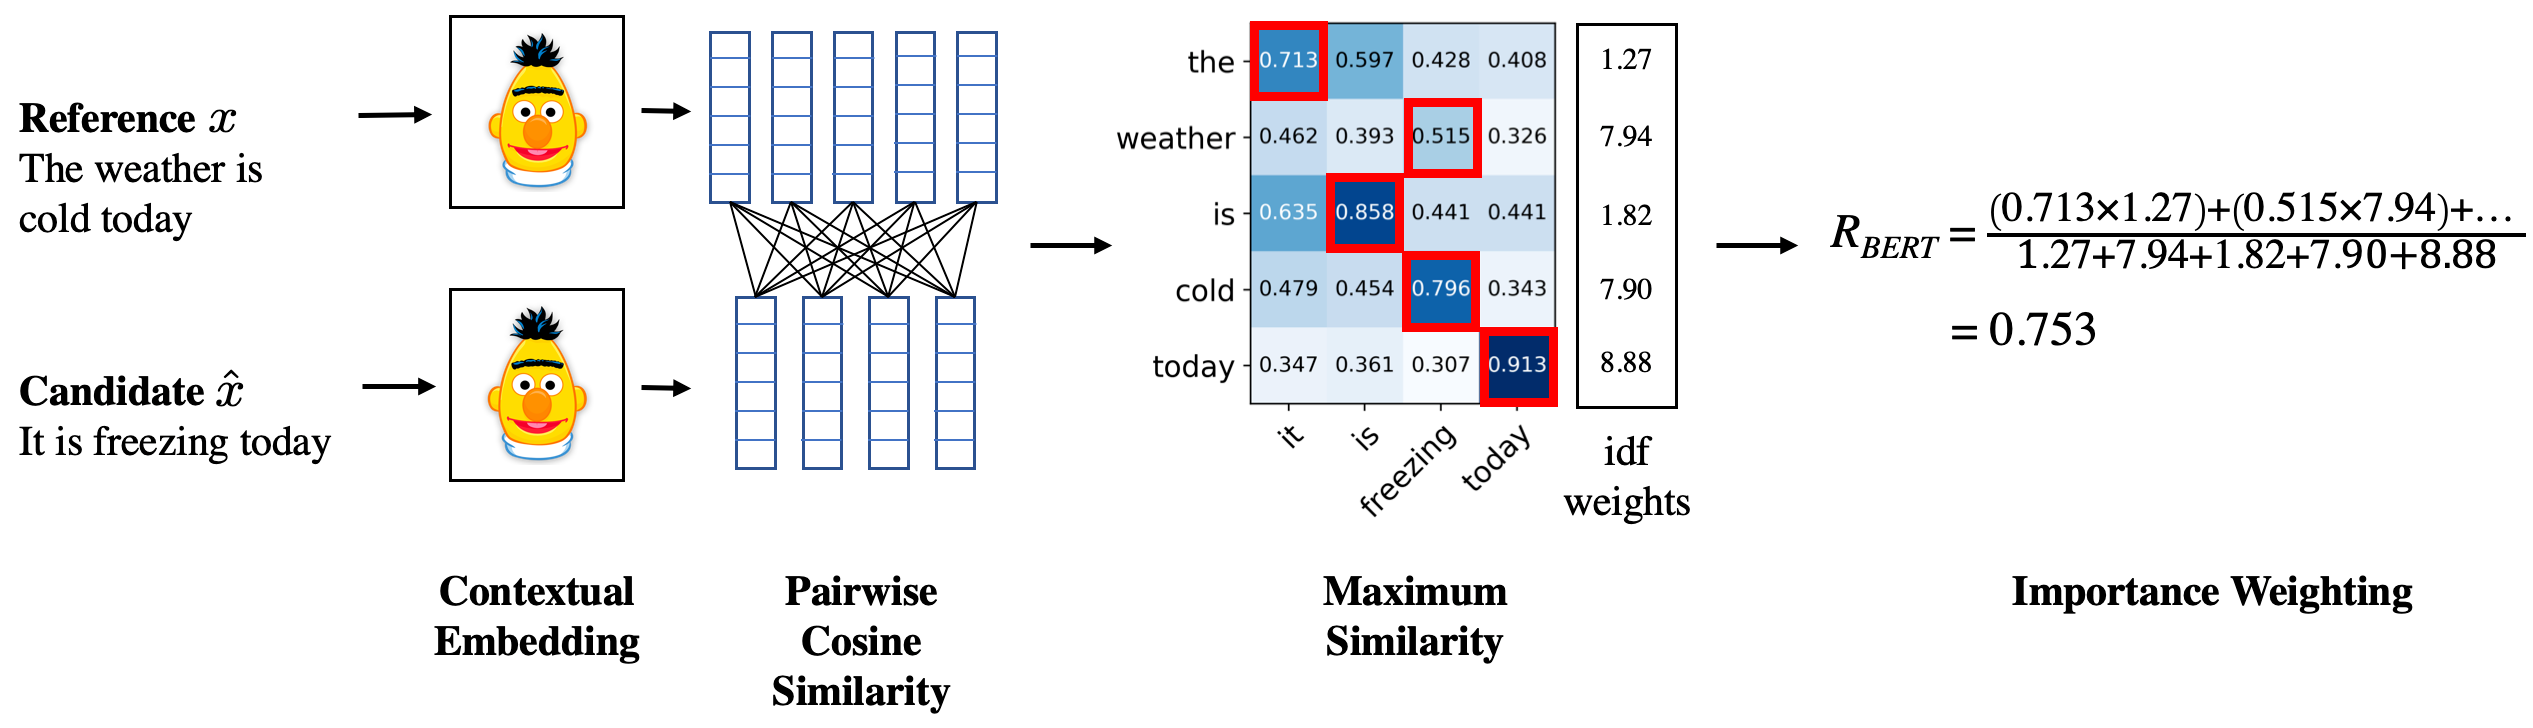

In [ ]:
# initialise the explainable sts metric
sim_explainer = ExplainableSTS('sbert') # to use sbert, pass argument 'sbert'

Investigating intra class similarity:

In [ ]:
pred_0 = [i for i in range(0,len(y)) if y[i]==0]
pred_1 = [i for i in range(0,len(y)) if y[i]==1]
pred_2 = [i for i in range(0,len(y)) if y[i]==2]
pred_3 = [i for i in range(0,len(y)) if y[i]==3]

In [ ]:
num_s=1000
s_0 = [x[i] for i in random.sample(pred_0,num_s)]
s_1 = [x[i] for i in random.sample(pred_1,num_s)]
s_2 = [x[i] for i in random.sample(pred_2,num_s)]
s_3 = [x[i] for i in random.sample(pred_3,num_s)]

In [ ]:
samp_0=[]
for entry in s_0:
  samp_0.append(",".join([f"{str(k)}={str(entry[k])}" for k in entry]))
samp_1=[]
for entry in s_1:
  samp_1.append(",".join([f"{str(k)}={str(entry[k])}" for k in entry]))
samp_2=[]
for entry in s_2:
  samp_2.append(",".join([f"{str(k)}={str(entry[k])}" for k in entry]))
samp_3=[]
for entry in s_3:
  samp_3.append(",".join([f"{str(k)}={str(entry[k])}" for k in entry]))

In [ ]:
sim_scores_0=[]
for i in range(num_s-1):
  sim_scores_0.append(sim_explainer(samp_0[i], samp_0[i+1]))
  # print('predicted similarity score:', sim_scores_0[i])

sim_avg_0 = sum(sim_scores_0)/num_s
print('Predicted mean similarity score of the sample from prediction 0:', sim_avg_0)

In [ ]:
sim_scores_1=[]
for i in range(num_s-1):
  sim_scores_1.append(sim_explainer(samp_1[i], samp_1[i+1]))
  # print('predicted similarity score:', sim_scores_1[i])

sim_avg_1 = sum(sim_scores_1)/num_s
print('Predicted mean similarity score of the sample from prediction 1:', sim_avg_1)

In [ ]:
sim_scores_2=[]
for i in range(num_s-1):
  sim_scores_2.append(sim_explainer(samp_2[i], samp_2[i+1]))
  # print('predicted similarity score:', sim_scores_2[i])

sim_avg_2 = sum(sim_scores_2)/num_s
print('Predicted mean similarity score of the sample from prediction 2:', sim_avg_2)

In [ ]:
sim_scores_3=[]
for i in range(num_s-1):
  sim_scores_3.append(sim_explainer(samp_3[i], samp_3[i+1]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_3 = sum(sim_scores_3)/num_s
print('Predicted mean similarity score of the sample from prediction 3:', sim_avg_3)

The class with the least intra class similarity is Failed.


The highest score is achieved by oom class.

Investigating inter class similarity:

In [ ]:
sim_scores_0_1=[]
for i in range(num_s):
  sim_scores_0_1.append(sim_explainer(samp_0[i], samp_1[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_0_1 = sum(sim_scores_0_1)/num_s
print('Predicted mean similarity score between predictions 0 and 1:', sim_avg_0_1)

In [ ]:
sim_scores_0_2=[]
for i in range(num_s):
  sim_scores_0_2.append(sim_explainer(samp_0[i], samp_2[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_0_2 = sum(sim_scores_0_2)/num_s
print('Predicted mean similarity score between predictions 0 and 2:', sim_avg_0_2)

In [ ]:
sim_scores_0_3=[]
for i in range(num_s):
  sim_scores_0_3.append(sim_explainer(samp_0[i], samp_3[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_0_3 = sum(sim_scores_0_3)/num_s
print('Predicted mean similarity score between predictions 0 and 3:', sim_avg_0_3)

In [ ]:
sim_scores_1_3=[]
for i in range(num_s):
  sim_scores_1_3.append(sim_explainer(samp_1[i], samp_3[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_1_3 = sum(sim_scores_1_3)/num_s
print('Predicted mean similarity score between predictions 1 and 3:', sim_avg_1_3)

In [ ]:
sim_scores_1_2=[]
for i in range(num_s):
  sim_scores_1_2.append(sim_explainer(samp_1[i], samp_2[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_1_2 = sum(sim_scores_1_2)/num_s
print('Predicted mean similarity score between predictions 1 and 2:', sim_avg_1_2)

In [ ]:
sim_scores_2_3=[]
for i in range(num_s):
  sim_scores_2_3.append(sim_explainer(samp_2[i], samp_3[i]))
  # print('predicted similarity score:', sim_scores_3[i])

sim_avg_2_3 = sum(sim_scores_2_3)/num_s
print('Predicted mean similarity score between predictions 2 and 3:', sim_avg_2_3)

The inter class similarity is pretty high across all pairs, the peak is in the oom/Time-out pair. This could be one of the factors that limit our performance.

Compairson between examples from different classes showing the features contribution:

In [ ]:
sim_score = sim_explainer(samp_0[0], samp_1[0])
print('predicted similarity score:', sim_score)

# get the explanation
sim_explainer.explain(samp_0[0], samp_1[0], plot=True)

In [ ]:
sim_score = sim_explainer(samp_0[0], samp_2[0])
print('predicted similarity score:', sim_score)

# get the explanation
sim_explainer.explain(samp_0[0], samp_2[0], plot=True)

In [ ]:
sim_score = sim_explainer(samp_0[0], samp_3[0])
print('predicted similarity score:', sim_score)

sim_explainer.explain(samp_0[0], samp_3[0], plot=True)

In [ ]:
sim_score = sim_explainer(samp_2[0], samp_3[0])
print('predicted similarity score:', sim_score)

sim_explainer.explain(samp_2[0], samp_3[0], plot=True)

In [ ]:
sim_score = sim_explainer(samp_2[0], samp_1[0])
print('predicted similarity score:', sim_score)

sim_explainer.explain(samp_2[0], samp_3[0], plot=True)

#### LIME explainability

In [ ]:
explainer_lime = lime.lime_tabular.LimeTabularExplainer(sbert.prepare_data(x[:10000]),
                                                        feature_names=[i for i in range(1,385)],
                                                        class_names=['completed','failed',
                                                                     'oom','time-out'],
                                                        verbose=True,
                                                        mode='classification')

probabilmente il problema risiede in predict proba perchè prova a reincodare quello che sta a sx, quindi cambiare predict proba in modo che non lo fa (in qualche modo) ma che prenda direttamente le cose encodate quindi a sx mettere tipo encode(x)

In [ ]:
j = 0
entry = s_2[j]
example = ",".join([f"{str(k)}={str(entry[k])}" for k in entry])
print(example)
exp = explainer_lime.explain_instance(sbert.encoder.encode(example), sbert.predict_proba, top_labels=4)

In [ ]:
exp.show_in_notebook()

In [ ]:
j = 0
entry = x[j]
example = ",".join([f"{str(k)}={str(entry[k])}" for k in entry])
exp = explainer_lime.explain_instance(sbert.encoder.encode(example), sbert.predict_proba, top_labels=4)

In [ ]:
exp.show_in_notebook()

#### SHAP explainability

In [ ]:
X_sampled = pd.DataFrame(sbert.prepare_data(s_2))
explainer = shap.TreeExplainer(sbert.classifier)
shap_values = explainer.shap_values(X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3][0], X_sampled.iloc[0])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[2], shap_values[2], X_sampled)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[3], shap_values[3], X_sampled)

In [ ]:
shap.summary_plot(shap_values, X_sampled, plot_type="bar")

### Sbert with XGBoost

https://paperswithcode.com/sota/sentence-classification-on-acl-arc

https://paperswithcode.com/task/sentence-classification

In [ ]:
sbertxg = SBertXGBoost()

In [ ]:
sbertxg.fit(x, y)

In [ ]:
y_predicted = sbertxg.predict(x_val)

In [ ]:
print(classification_report(list(map(lambda e: d[e], y_val)), list(map(lambda e: d[e], y_predicted))))

## GATE

Gated Feature Learning Units select what information to use from the raw features to create the best set of features. This approach could be beneficial in our case were we have pretty high intra class similarity.
This learned representation is then processed using an ensemble of Differentiable Non Linear Decision Trees. During the last step the output of all the trees are re-weighted using self-attention for the final prediction of the model.


In [ ]:
# Train e test D1
df_train, df_val = manage_dataset(setup=0, real = 1)

# Train e test D2
# df_train, df_val = manage_dataset(setup=1, real = 1)

# Train D1 e test D2
#df_train, df_val = manage_dataset(setup=2, real = 1)

# Train D2 e test D1
#df_train, df_val = manage_dataset(setup=3, real = 1)

In [ ]:
cat_cols = [
    "command",
    "name",
    "account",
    "partition",
    "qos",
    "req_nodes"
    ]
num_cols = [
    "user_id",
    "group_id",
    "cpus_per_task",
    "time_limit",
    "cpu",
    "mem",
    "node",
    "gres/gpu",
]
target=["job_state"]

In [ ]:
data_config = DataConfig(
    target=target, #target should always be a list.
    continuous_cols=num_cols,
    categorical_cols=cat_cols,
)

trainer_config = TrainerConfig(
    auto_lr_find=True, # Runs the LRFinder to automatically derive a learning rate
    batch_size=128,
    max_epochs=10,
    early_stopping="valid_loss", # Monitor valid_loss for early stopping
    early_stopping_mode = "min", # Set the mode as min because for val_loss, lower is better
    early_stopping_patience=1, # No. of epochs of degradation training will wait before terminating
    checkpoints="valid_loss", # Save best checkpoint monitoring val_loss
    load_best=True, # After training, load the best checkpoint
)

optimizer_config = OptimizerConfig()

head_config = LinearHeadConfig(
    layers="", # No additional layer in head, just a mapping layer to output_dim
    dropout=0.2,
    initialization="kaiming"
).__dict__ # Convert to dict to pass to the model config (OmegaConf doesn't accept objects)

In [ ]:
model_config = GatedAdditiveTreeEnsembleConfig(
    task="classification",
    learning_rate = 1e-3,
    head = "LinearHead", #Linear Head
    head_config = head_config, # Linear Head Config
)

tabular_model = TabularModel(
    data_config=data_config,
    model_config=model_config,
    optimizer_config=optimizer_config,
    trainer_config=trainer_config,
)
tabular_model.fit(train=df_train.iloc[:,1:])
#tabular_model.evaluate(df_val.iloc[:,1:])

In [ ]:
y_ga = tabular_model.predict(df_val.iloc[:,1:])

In [ ]:
y_ga

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,15])), list(map(lambda e: d[e], y_ga["prediction"]))))

### SHAP explainability

In [ ]:
def f(X):
    # return tabular_model.predict(X)['prediction']
    return tabular_model.predict(pd.DataFrame(X, columns = df_train.iloc[:50,1:].columns))['prediction']

In [ ]:
explainer = shap.KernelExplainer(f, df_train.iloc[:50,1:])

In [ ]:
shap.initjs()
shap_values = explainer.shap_values(df_train.iloc[299,1:], nsamples=500)
shap.force_plot(explainer.expected_value, shap_values, df_train.iloc[299,1:])

In [ ]:
shap_values50 = explainer.shap_values(df_train.iloc[:20,1:], nsamples=30)

startyed fit 12:53
ep 1 done 13:26
pred started rem 42 min done
explaining

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values50, df_train.iloc[:20,1:])

In [ ]:
shap.summary_plot(shap_values50, df_train.iloc[:20,1:], plot_type="bar")

## TabTransformer

### Tab configs

In [ ]:
df_train.drop(['job_id'], axis=1, inplace=True)
df_val.drop(['job_id'], axis=1, inplace=True)

In [ ]:
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"
df_train['user_id']= pd.to_numeric(df_train['user_id'])
df_train['group_id']= pd.to_numeric(df_train['user_id'])
df_train.to_csv(train_data_file, index=False, header=False)
df_val.to_csv(test_data_file, index=False, header=False)

In [ ]:
# A list of the numerical feature names.
NUMERIC_FEATURE_NAMES = [
    "user_id",
    "group_id",
    "cpus_per_task",
    "time_limit",
    "cpu",
    "mem",
    "node",
    "gres/gpu",
]

df_full = pd.concat([df_train, df_val], axis=0)
# A dictionary of the categorical features and their vocabulary.
CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "command": sorted(list(df_full["command"].unique())),
    "name": sorted(list(df_full["name"].unique())),
    "account": sorted(list(df_full["account"].unique())),
    "partition": sorted(list(df_full["partition"].unique())),
    "qos": sorted(list(df_full["qos"].unique())),
    "req_nodes": sorted(list(df_full["req_nodes"].unique()))
}
# Name of the column to be used as instances weight.
# WEIGHT_COLUMN_NAME = "fnlwgt"
# A list of the categorical feature names.
CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())
# A list of all the input features.
FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES
# The name of the target feature.
TARGET_FEATURE_NAME = "job_state"
# A list of column default values for each feature.
COLUMN_DEFAULTS = [
    [0.0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME]
    else [""]
    for feature_name in df_train.columns
]
# A list of the labels of the target features.
TARGET_LABELS = [0, 1, 2, 3]

In [ ]:
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
DROPOUT_RATE = 0.2
BATCH_SIZE = 256
NUM_EPOCHS = 5

NUM_TRANSFORMER_BLOCKS = 3  # Number of transformer blocks. #3
NUM_HEADS = 4  # Number of attention heads. #4
EMBEDDING_DIMS = 16  # Embedding dimensions of the categorical features. #16
MLP_HIDDEN_UNITS_FACTORS = [
    2,
    1,
]  # MLP hidden layer units, as factors of the number of inputs.
NUM_MLP_BLOCKS = 2  # Number of MLP blocks in the baseline model.

### Tab utils

In [ ]:
def get_dataset_from_pd(csv_file_path, batch_size=128, shuffle=False):
    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=df_train.columns,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=False,
        na_value="?",
        shuffle=shuffle,
    )
    return dataset.cache()

In [ ]:
def run_experiment(
    model,
    train_data_file,
    test_data_file,
    num_epochs,
    learning_rate,
    weight_decay,
    batch_size,
):

    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

    train_dataset = get_dataset_from_pd(train_data_file, batch_size, shuffle=True)
    validation_dataset = get_dataset_from_pd(test_data_file, batch_size)

    print("Start training the model...")
    history = model.fit(
        train_dataset, epochs=num_epochs, validation_data=validation_dataset
    )
    print("Model training finished")

    _, accuracy = model.evaluate(validation_dataset, verbose=0)

    print(f"Validation accuracy: {round(accuracy * 100, 2)}%")

    return history

In [ ]:
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = tf.keras.layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [ ]:
def encode_inputs(inputs, embedding_dims):

    encoded_categorical_feature_list = []
    numerical_feature_list = []

    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:

            # Get the vocabulary of the categorical feature.
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            # Create a lookup to convert string values to an integer indices.
            # Since we are not using a mask token nor expecting any out of vocabulary
            # (oov) token, we set mask_token to None and  num_oov_indices to 0.
            lookup = tf.keras.layers.StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int",
            )

            # Convert the string input values into integer indices.
            encoded_feature = lookup(inputs[feature_name])

            # Create an embedding layer with the specified dimensions.
            embedding = tf.keras.layers.Embedding(
                input_dim=len(vocabulary), output_dim=embedding_dims
            )

            # Convert the index values to embedding representations.
            encoded_categorical_feature = embedding(encoded_feature)
            encoded_categorical_feature_list.append(encoded_categorical_feature)

        else:

            # Use the numerical features as-is.
            numerical_feature = tf.expand_dims(inputs[feature_name], -1)
            numerical_feature_list.append(numerical_feature)

    return encoded_categorical_feature_list, numerical_feature_list

In [ ]:
def create_mlp(hidden_units, dropout_rate, activation, normalization_layer, name=None):

    mlp_layers = []
    for units in hidden_units:
        mlp_layers.append(normalization_layer),
        mlp_layers.append(layers.Dense(units, activation=activation))
        mlp_layers.append(layers.Dropout(dropout_rate))

    return keras.Sequential(mlp_layers, name=name)

In [ ]:
def create_tabtransformer_classifier(
    num_transformer_blocks,
    num_heads,
    embedding_dims,
    mlp_hidden_units_factors,
    dropout_rate,
    use_column_embedding=False,
):

    # Create model inputs.
    inputs = create_model_inputs()
    # encode features.
    encoded_categorical_feature_list, numerical_feature_list = encode_inputs(
        inputs, embedding_dims
    )
    # Stack categorical feature embeddings for the Tansformer.
    encoded_categorical_features = tf.stack(encoded_categorical_feature_list, axis=1)
    # Concatenate numerical features.
    numerical_features = layers.concatenate(numerical_feature_list)

    # Add column embedding to categorical feature embeddings.
    if use_column_embedding:
        num_columns = encoded_categorical_features.shape[1]
        column_embedding = layers.Embedding(
            input_dim=num_columns, output_dim=embedding_dims
        )
        column_indices = tf.range(start=0, limit=num_columns, delta=1)
        encoded_categorical_features = encoded_categorical_features + column_embedding(
            column_indices
        )

    # Create multiple layers of the Transformer block.
    for block_idx in range(num_transformer_blocks):
        # Create a multi-head attention layer.
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads,
            key_dim=embedding_dims,
            dropout=dropout_rate,
            name=f"multihead_attention_{block_idx}",
        )(encoded_categorical_features, encoded_categorical_features)
        # Skip connection 1.
        x = layers.Add(name=f"skip_connection1_{block_idx}")(
            [attention_output, encoded_categorical_features]
        )
        # Layer normalization 1.
        x = layers.LayerNormalization(name=f"layer_norm1_{block_idx}", epsilon=1e-6)(x)
        # Feedforward.
        feedforward_output = create_mlp(
            hidden_units=[embedding_dims],
            dropout_rate=dropout_rate,
            activation=keras.activations.gelu,
            normalization_layer=layers.LayerNormalization(epsilon=1e-6),
            name=f"feedforward_{block_idx}",
        )(x)
        # Skip connection 2.
        x = layers.Add(name=f"skip_connection2_{block_idx}")([feedforward_output, x])
        # Layer normalization 2.
        encoded_categorical_features = layers.LayerNormalization(
            name=f"layer_norm2_{block_idx}", epsilon=1e-6
        )(x)

    # Flatten the "contextualized" embeddings of the categorical features.
    categorical_features = layers.Flatten()(encoded_categorical_features)
    # Apply layer normalization to the numerical features.
    numerical_features = layers.LayerNormalization(epsilon=1e-6)(numerical_features)
    # Prepare the input for the final MLP block.
    features = layers.concatenate([categorical_features, numerical_features])

    # Compute MLP hidden_units.
    mlp_hidden_units = [
        factor * features.shape[-1] for factor in mlp_hidden_units_factors
    ]
    # Create final MLP.
    features = create_mlp(
        hidden_units=mlp_hidden_units,
        dropout_rate=dropout_rate,
        activation=keras.activations.selu,
        normalization_layer=layers.BatchNormalization(),
        name="MLP",
    )(features)

    # Add a sigmoid as a binary classifer.
    outputs = layers.Dense(units=4, activation="softmax", name="softmax")(features)
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

### Training

In [ ]:
tabtransformer_model = create_tabtransformer_classifier(
    num_transformer_blocks=NUM_TRANSFORMER_BLOCKS,
    num_heads=NUM_HEADS,
    embedding_dims=EMBEDDING_DIMS,
    mlp_hidden_units_factors=MLP_HIDDEN_UNITS_FACTORS,
    dropout_rate=DROPOUT_RATE,
)

print("Total model weights:", tabtransformer_model.count_params())
keras.utils.plot_model(tabtransformer_model, show_shapes=True, rankdir="LR")

In [ ]:
tf.debugging.disable_traceback_filtering()
history = run_experiment(
    model=tabtransformer_model,
    train_data_file=train_data_file,
    test_data_file=test_data_file,
    num_epochs=NUM_EPOCHS,
    learning_rate=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
    batch_size=BATCH_SIZE,
)

In [ ]:
y_tab = tabtransformer_model.predict(get_dataset_from_pd(test_data_file))

In [ ]:
print(classification_report(list(map(lambda e: d[e], df_val.iloc[:,14])), list(map(lambda e: d[e], np.argmax(y_tab, axis=1)))))

# References

* https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8914926/

* https://arxiv.org/pdf/2301.05176.pdf

* https://pdfs.semanticscholar.org/2601/ab02de7563e644fb94604ea7f786900c906a.pdf

* https://arxiv.org/abs/1904.09675

* https://github.com/yg211/explainable-metrics